The goal of this notebook is to write code that given a specific nucleus to produce, an efficiency will be calculated based on the required input energy, target cross sections, and power density of the product to find the optimal use of radionuclide production as a method of energy storage. 

This can also be used to generate a theoretical maximum of storage efficiency for each product. 

To start, we'll need cross sections. 

Will attempt to download the entirety of (or write a very fast query for) 
https://doi.org/10.1016/j.nds.2018.02.001

Pivoting to use Jeff32 since it has a singular directory with many neutron cross sections for different targets. https://www.oecd-nea.org/dbforms/data/eva/evatapes/jeff_32/

JENDL appears to have both neutron and proton cross section data for transmutation, so this seems very promising. It uses the ENDF6 format https://www-nds.iaea.org/public/endf/ 

Finally found the database explorer for ENDF, will be using this as well. 
https://www-nds.iaea.org/exfor/e4explorer.htm 

#Derivations for nuclide production
Consider a thin target $T$ with a cross section $\sigma$ at an energy level of $E_{particle}$. We have for the production rate (from "Industrial Accelerators and their Applications")
\begin{equation}
\frac{dR}{dx} = In\sigma
\end{equation}
Integrating, we have for the number of nuclei produced
\begin{equation}
N = \int\int\frac{dR}{dx}dxdt = \int\int In\sigma dxdt
\end{equation}
Where $R$ is the production rate in atoms per second, $x$ is the depth of the material, $n$ is the nuclei/volume, and $\sigma$ is the cross section in area/nucleus, and $I$ is the flow rate in moles/second of the beam. It's also important to note that the beam energy is also a function of $x$. Thus we have for the energy input 
\begin{equation}
E_{in} = \int IE_{incident \ particle} dt
\end{equation}
For a given decay chain whose parent nucleus has $N$ particles we have for a pure amount of this substance a specific energy (energy density) $\rho_{E}$ of 
\begin{equation}
E_{out} = Z_{product}N\rho_{E}
\end{equation}
where $Z$ is the mass number of the product and $N_A$ is Avogadro's constant. 
Thus we have for the energy efficiency of this process, 
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}N\rho_{E}}{\int IE_{incident \ particle} dt} =  
\frac{Z_{product}\rho_{E}\int\int In\sigma dxdt}{\int IE_{incident \ particle} dt}
\end{equation}

##Thin target case with constant beam current and energy
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}\rho_{E} In\sigma xt}{IE_{incident \ particle}t} = \frac{Z\rho_{E} n\sigma x}{E_{incident \ particle}}
\end{equation}
Rearranging to find the energy efficiency per thickness of material 
\begin{equation}
\frac{E_{out}}{xE_{in}} = \frac{Z_{product}\rho_{E} n\sigma }{E_{incident \ particle}}
\end{equation}
Thus, our figure of merit for a reaction will be energy efficiency per thickness of material. 
We'll be dealing with a lot of data and computations so I'll use Julia instead of Python. 

In [11]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
#using Plots
using PlotlyJS
using Printf
using SymPy
using PDFIO
#plotlyjs()
data_dir = ("C:\\Cross-Section-Data\\")
cross_section_dir = data_dir
import_data_dir = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData"

"C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData"

In [2]:
#https://docs.juliahub.com/SymPy/ 
P, N, x, Σ, σR, σT, ρ, M, A = symbols("P, N, x, Σ, σ_R, σ_T, ρ, M, A", positive = true, real = true)
N = ρ * A/ M
Σ = N * σR  
P = integrate(Σ*exp(-Σ*x), (x, 0, x))
P 

     -A*x*ρ*σ_R 
     -----------
          M     
1 - e           

In [ ]:
## string to varname function, see
## https://groups.google.com/forum/#!topic/julia-dev/z-dyQ_jUgk8
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    @eval (($s) = ($v))
end
string_as_varname("x_1", 100)
x_1

100

#Now I will find the probability of a given reaction for a thick target (on the order of meters). 

Where $P$ is the probability of a specific nuclear reaction occuring (e.g. aborbing a gamma ray and ejecting a neutron), $r$ is the reaction cross section, $x$ is the thickness of the target in meters, $t$ is the total cross section ($t>r>0$) and $a$ is the cross section of all reactions that are mutually exclusive with the reaction associated with $r$. We define $k$
 
\begin{equation}
\begin{split}
k = \frac{-\rho N_A}{M}
\end{split}
\end{equation}
 
Where $\rho$ is the mass density in kg/m $^3$, $M$ is the molar mass in kg, and $N_A$ is Avogadro's number.
Note that I have not yet accounted for other reactions included in the total cross section that would prevent a different reaction. 
Are there any reactions that would prevent a given different reaction? If so, which?

In [141]:
#This cell requires a sage Jupyter server. https://www.sagemath.org/
from IPython.display import Markdown as md
import sympy
#https://stackoverflow.com/questions/18878083/can-i-use-variables-on-an-ipython-notebook-markup-cell
x, k, t, r, d, a, b = var('x k t r d a b', domain = 'positive')
#k = var('k', domain = 'real')
#what is the probability that the reaction doesn't happen?
#probability of another reaction or no reaction
another_reaction = 1-exp(a*k*x)
no_reaction = exp(t*k*x)
reaction_doesnt_happen = no_reaction + another_reaction 
#These events are mutually exclusive!!
reaction = 1 - reaction_doesnt_happen
d = diff(reaction, x)
x_max = sympy.solve(d == 0, x)[0]._sage_() #convert from sympy object
reaction_max = reaction.substitute(x = x_max)#.full_simplify()
md("\\begin{split}"+
"\\Large P = 1-(%s+%s)=%s"%(latex(no_reaction),latex(another_reaction),latex(reaction))+
"\\\\"+ "\\Large \\frac{dP}{dx} = %s"%(latex(d))+ "\\\\"
"\\Large x_{p_{max}} = %s"%latex(x_max)+ "\\\\" +
"\\Large P_{max} = %s"%latex(reaction_max)+
"\\end{split}")

\begin{split}\Large P = 1-(e^{\left(k t x\right)}+-e^{\left(a k x\right)} + 1)=e^{\left(a k x\right)} - e^{\left(k t x\right)}\\\Large \frac{dP}{dx} = a k e^{\left(a k x\right)} - k t e^{\left(k t x\right)}\\\Large x_{p_{max}} = \frac{\log\left(\frac{t}{a}\right)}{{\left(a - t\right)} k}\\\Large P_{max} = \left(\frac{t}{a}\right)^{\frac{a}{a - t}} - \left(\frac{t}{a}\right)^{\frac{t}{a - t}}\end{split}

In [33]:
#julia implementation of the above
P_max(t,a) = (t/a)^(a/(BigFloat(a)-BigFloat(t))) - (t/a)^(t/(BigFloat(a)-BigFloat(t)))
P_max(BigFloat(10)^-24,BigFloat(10)^-25)

0.6968373144130143537540115063832723503929003693657702617622527796681775277934392

In [32]:
x_max(t,a,k) = (log(t/a))/(k*(BigFloat(a)-BigFloat(t)))
x_max(BigFloat(10)^-24,BigFloat(10)^-25,-BigFloat(10)^24)

2.558427881104495204464434949649293564001223876254192195592586556630636232974871

The order of magnitude estimates for the cross sections listed look promising!

Interestingly, the maximum probability of the reaction occuring appears to only depend on the total cross section, $t$, and the cross sections for reactions that are mutually exclusive with a given reaction, $a$. However, the corresponding target thickness does also depend on the target's molar mass and density.

If none of the other reactions are mutually exclusive with a given reaction with a cross section $r$, then we instead have

In [140]:
reaction = 1 - exp(k*r*x)
md("\\begin{split}\\Large P = %s\\end{split}"%latex(reaction))

\begin{split}\Large P = -e^{\left(k r x\right)} + 1\end{split}

Which agrees with Section 2.5.1 of "The Physics of Nucear Reactors". 

Now I will plot $P_{max}$ and $x_{max}$ for neutron ejection as a function of the energy of an incoming gamma ray striking a deuterium target. 

If none of the other possible reactions are mutually exclusive with the reaction associated with a given reaction with cross section $r$ then we instead have

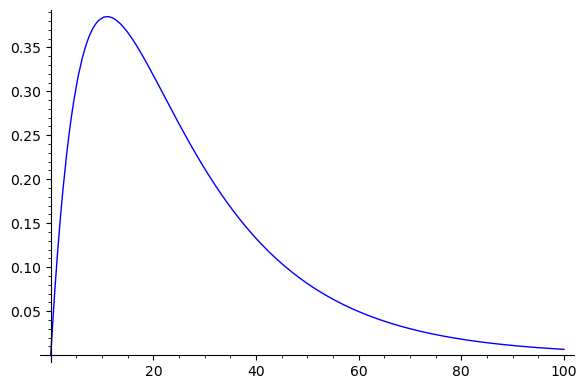

In [8]:
t = .1
k = -1
r = t / 2
another_reaction = 1-exp((t-r)*k*x)
#are cross sections additive?
no_reaction = exp(t*k*x)
reaction_doesnt_happen = no_reaction + another_reaction - (another_reaction*no_reaction)
reaction = 1- reaction_doesnt_happen
plot(reaction, (x, 0, 100))

From Section 2.5.1 of "The Physics of Nucear Reactors" we have for the probability of reaction for a path length $x$ with target with nuclear cross section $\sigma$, molar mass in kg $M$, and mass density in kg/m $^3$ $\rho$, and $A$ is Avogadro's number.
\begin{equation}
\begin{split}
P = (1-e^{kx})e^{(k+a)x}\\
\end{split}
\end{equation}

Here we define a dictionary that matches each value of MT in an ENDF6-formatted data to a particular reaction. 

We then will also loop through all of the subdirectories in a directory, then unzip all of the compressed files to that directory that don't already have an unzipped counterpart in that directory.

In this notation $(z, 2nd)$ refers to a reaction where some matter strikes a target and produces 2 neutrons, a deuteron, and a residual.

Furthermore, "(z, n ^3He)" refers the production of a neutron, a Helium-nucleus, and a residual. 

Subscripts refer to the energy state.

(z, $\gamma$) refers to radiative capture
The below code assumes that the complete reaction is in the same line as the MT number. 

Luckily the only time a subscript could be confused with a coefficient is the case of $^3$ He but from just reading the original PDF, it is clear that He never has a coefficient other than 1, and that seeing "3 He" in the text file always refers to a helium-3 nucleus. 

The function matches_pattern returns whether or not a given section of the txt file defines an MT value and the number of digits in the MT value. Conveniently, a subscript is never followed by a character and is always after the nucleus it describes the energy level of.

In [3]:
# import text file as string with Julia
mt_path = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData\\mt.txt"
function matches_pattern(long_string, index = 1)
    if isdigit(long_string[index]) && occursin(",", long_string)
        if  isdigit(long_string[index+1])
            if isdigit(long_string[index+2])
                #3 digit number
                return (long_string[index+3:index+4] == " (", 3)  
            elseif long_string[index+2] == ' ' 
                #two digit number 
                return (long_string[index+3] == '(', 2)
            end
        elseif long_string[index+1] == ' ' 
            #one digit number 
            return (long_string[index+2] == '(', 1)
        end
    end
    return (false, 0)
end
function define_MTs(mt_path)
    open(mt_path) do file
        mt_reactions, mt_details = Dict([]), Dict([])
        long_string = read(mt_path, String)
        index = 0
        print(index)
        while true
            index += 1
            if (index > length(long_string) - 12)
                return mt_reactions, mt_details
            end
            is_MT, MT_length = matches_pattern(long_string[index:index+6])
            if is_MT
                try
                    MT = parse(Int64, long_string[index:index+MT_length])
                    reaction_end = collect(findfirst(")", long_string[index:end]))[1] + index
                    reaction = strip(long_string[index+MT_length+1: reaction_end])
                    if !(reaction == "(Unassigned)")
                        println(MT, reaction)
                        mt_reactions[MT] = reaction
                        #now to get the details
                        details_end = collect(findfirst(".\r", long_string[reaction_end+1:end]))[1] 
                        details_end += reaction_end + 1
                        details = strip(long_string[reaction_end+1: details_end])
                    details = replace(details, "\r" => " " )
                        details = replace(details, "\n" => "" )
                        mt_details[MT] = details
                        index = details_end
                    else
                        index = reaction_end                     
                    end
                catch
                    println(index)
                end
            end
        end 
    end
end
mt_reactions, mt_details = define_MTs(mt_path)
CSV.write("C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_reactions.csv", mt_reactions)
CSV.write("C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_details.csv", mt_details)

01(n,total)
2(z,z0)
3(z,nonelas.)
4(z,n)
5(z,anything)
10(z,contin.)
11(z,2nd)
16(z,2n)
17(z,3n)
18(z,fission)
19(n,f)
20(n,nf)
21(n,2nf)
22(z,nα)
23(n,n3α)
24(z,2nα)
25(z,3nα)
27(n,abs)
28(z,np)
29(z,n2α)
30(z,2n2α)
32(z,nd)
33(z,nt)
34(z,n3He)
35(z,nd2α)
36(z,nt2α)
37(z,4n)
38(n,3nf)
41(z,2np)
42(z,3np)
44(z,n2p)
45(z,npα)
50(y,n0)
51(z,n1)
52(z,n2)
90(z,n40)
91(z,nc)
101(n,disap)
102(z,γ)
103(z,p)
104(z,d)
105(z,t)
106(z,3He)
107(z,α)
108(z,2α)
109(z,3α)
111(z,2p)
112(z,pα)
113(z,t2α)
114(z,d2α)
115(z,pd)
116(z,pt)
117(z,dα)
151(n,RES)
152(z,5n)
202(z,Xγ)
203(z,Xp)
204(z,Xd)
205(z,Xt)
206(z,X3He)
207(z,Xα)
208(z,Xπ+)
209(z,Xπ0)
210(z,Xπ−)
211(z,Xμ+)
212(z,Xμ−)
213(z,Xκ+)
214(z,Xκ0 long )
215(z,Xκ0 short)
216(z,Xκ−)
217(z,Xp−)
218(z,Xn−)
251(n,...)
252(n,...)
253(n,...)
450(z,...)
451(z,...)
452(z,...)
454(z,...)
455(z,...)
456(z,...)
457(z,...)
458(n,...)
459(z,...)
460(z,...)
600(z,p0)
601(z,p1)
602(z,p2)
603(z,p3)
604(z,p4)
649(z,pc)
650(z,d0)
651(z,d1)
652(z,d2)
699(z,dc)
700(z,t

"C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_details.csv"

Now to filter the reactions for those that are sufficiently explicit.

In [4]:
MTs = [key for key in keys(mt_reactions)]
reactions = [value for value in values(mt_reactions)]
symbol_dict = Dict([
            ("n", (0, 1)),
            ("t", (1, 3)), #2 neutrons, 1 proton
            ("d", (1, 2)),
            ("p", (1, 1)),
            ("α", (2, 4)),
            ("γ", (0, 0)),
            ("3 He", (2, 3)),
            ('c', (0,0)) #reverse to continuum emission
        ])
reaction_symbols = [key for key in keys(symbol_dict)]

function find_difference(term, projectile = (0,0))
    #e.g. term = "n"
    difference = (0, 0) #(Z, A)
    if occursin("z", term)
        difference = (projectile[1], projectile[2])
    end
    #now to search for instance of any of the keys in term
    for key in reaction_symbols
        if occursin(key, term)
            sub_difference = (0, 0)
            key_index = collect(findfirst(key, term))[1]
            sub_difference = symbol_dict[key]
            #check for coefficient
            if key_index > 1 && isdigit(term[key_index-1])
                coefficient = parse(Int64, term[key_index-1])
                sub_difference = (sub_difference[1] * coefficient, 
                    sub_difference[2] * coefficient)
            end
            difference = (difference[1] + sub_difference[1], difference[2] + sub_difference[2])
        end
    end
    return difference     
end


#each nucleus is represented by a tuple of (Z, A)
function interpret_reaction(reaction, projectile)
    comma_index = collect(findfirst(",", reaction))[1]
    reaction = collect(reaction)
    added = reaction[2:comma_index-1]
    ejected = reaction[comma_index+1:length(reaction)-1]
    #the valid option are n, t, d, p, α, γ, He
    # a number followed by a letter is a coefficient
    # a letter followed by a number is an energy level.
    # a letter followed by c means continuum emission of that particle
    #each value will be added or subtracted from the target
    added_difference = find_difference(string(added), projectile) 
    ejected_difference = find_difference(string(ejected))
    reaction = (added_difference[1] - ejected_difference[1], 
                added_difference[2] - ejected_difference[2])
    return reaction
end



interpret_reaction (generic function with 1 method)

The function below returns a dictionary where the keys are a tuple of the form (ΔZ,ΔA) and the values are MT numbers that correspond to such a reaction. The projectiles are an important input to specify, as many of the reactions involve fusion of at least part of the projectile (if its baryonic) and the target. 

In [5]:
function find_corresponding_MTs(projectile)    
    interpreted_MTs = Dict([])
    for MT in MTs
        try
            interpreted_MTs[MT] = interpret_reaction(mt_reactions[MT], projectile)
        catch
            println(MT)
        end
    end
    #details = [value for value in values(mt_details)]
    #will write test cases later
    interpretations = [value for value in values(interpreted_MTs)]
    #there are many reactions that yield the same nucleus. 
    possible_changes_in_nucleus = unique(interpretations)
    corresponding_MTs = Dict([])
    for change in possible_changes_in_nucleus
        corresponding_MTs[change] = [key for key in keys(interpreted_MTs) 
                                if interpreted_MTs[key] == change]
    end
    return corresponding_MTs
end

projectile_dict = Dict(["electron" => (0,0), "neutron"  => (0,1), 
    "proton" => (1,1), "deuteron" => (1,2), "tritium" => (1,3), 
    "alpha" => (2,2), "gamma" => (0,0), "3He"  => (2,3)])

gamma_MTs = find_corresponding_MTs(projectile_dict["gamma"])
proton_MTs = find_corresponding_MTs(projectile_dict["proton"])
alpha_MTs = find_corresponding_MTs(projectile_dict["alpha"])
tritium_MTs = find_corresponding_MTs(projectile_dict["tritium"])
neutron_MTs = find_corresponding_MTs(projectile_dict["neutron"])
deuteron_MTs = find_corresponding_MTs(projectile_dict["deuteron"])
helium3_MTs = find_corresponding_MTs(projectile_dict["3He"])
#unsure how to represent a positron. It it (-1,-1) ? 

Dict{Any, Any} with 16 entries:
  (1, 2)   => [603, 111, 203, 103, 217, 600, 649, 601, 604, 602]
  (-1, -3) => [114, 117, 45]
  (0, -2)  => [30, 25, 29, 24, 22]
  (-1, -2) => [112, 1]
  (-2, -2) => [101]
  (1, -1)  => [5, 10, 33]
  (0, -1)  => [207, 801, 849, 108, 50, 116, 109, 107, 800]
  (2, 2)   => [875, 90, 4, 91, 218, 52, 34, 18, 16, 891, 876, 152, 17, 37, 214,…
  (-1, -5) => [36]
  (2, 3)   => [210, 457, 460, 456, 451, 216, 208, 2, 211, 202  …  213, 450, 106…
  (1, 0)   => [700, 32, 215, 205, 11, 702, 749, 105, 701]
  (0, 0)   => [115, 20, 21, 38]
  (-1, -4) => [35, 113]
  (1, 1)   => [699, 650, 104, 651, 28, 41, 204, 42, 652, 44]
  (0, 1)   => [251, 253, 151, 751, 750, 27, 458, 799, 19, 252]
  (-2, -4) => [23]

Now to use each dictionary of the MTs and nuclear reactions to find the set of target nuclei and corresponding projectiles. The next step is to find the relative abundances (and cost?) of each target nucleus, and then to loop through the nuclear cross section data. By finding the cross section as a function of energy for each target and projectile, then substituting each cross section into the formula for probability of reaction and dividing it by the energy of the projectile (including the energy to manufacture it), and comparing it to the molar energy density of the product this will give the energy efficiency of radioisotope energy storage.

nested_projectile_dict is a nested dictionary, where each key is the name of a projectile and each value is a dictionary which has keys consisting of the possible $(ΔZ,ΔA)$ of the target in nuclear reactions corresponding to MTs defined for ENDF6-formatted nuclear data.

In [6]:
nested_projectile_dict = Dict(["gamma" => gamma_MTs, 
            "proton" => proton_MTs, "alpha" => alpha_MTs,
            "tritium" => tritium_MTs, "neutron" => neutron_MTs,
            "deuteron" => deuteron_MTs, "3He" => helium3_MTs])
projectiles = [key for key in keys(nested_projectile_dict)]

7-element Vector{String}:
 "deuteron"
 "proton"
 "alpha"
 "gamma"
 "neutron"
 "tritium"
 "3He"

In [7]:
products_path = "C:\\Users\\engin\\Downloads\\SortedPowerDensities.csv"
power_densities = CSV.read(products_path, DataFrame) 
products = power_densities[!, :2] #the isotope names are the second column
#now to write each isotope in the (Z, A) format

#list of the element symbols from the periodic table up to 118
element_symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", 
"Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", 
"Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", 
"Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", 
"Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", 
"Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", 
"Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", 
"Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", 
"Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", 
"Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"]

function write_in_z_a_format(isotope)
    char_array = collect(isotope)
    index = 1
    try
        while isdigit(char_array[index])
            index += 1
        end
        index -= 1
        a = parse(Int64, join(char_array[1:index]))
        z_as_string = join(char_array[index+1:end])
        if z_as_string == "n"
            z = 0
        else
            z = findfirst(x->x == z_as_string, element_symbols)
        end
        return (z, a)
    catch 
        error_message = "Error in isotope " * isotope
        println(error_message)
        return error_message
    end 
end
    #isotope is a string
z_a_products = [write_in_z_a_format(product) for product in products]

3192-element Vector{Tuple{Int64, Int64}}:
 (82, 218)
 (81, 215)
 (81, 216)
 (83, 219)
 (80, 214)
 (80, 211)
 (81, 214)
 (80, 213)
 (84, 220)
 (83, 220)
 ⋮
 (88, 202)
 (20, 58)
 (89, 218)
 (108, 266)
 (45, 88)
 (87, 215)
 (28, 49)
 (86, 217)
 (80, 173)

Now to import all naturally occuring isotopic abundances to evaluate whether or not a potential target is naturally occuring or would need to be produced. 

In [8]:
file_path = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData\\IsotopicAbundances.txt"
file_as_array = split(open(f->read(f, String), file_path), "\n")
file_as_array
#I want to make a dictionary where they keys are the isotope and the values are the abundance
file_as_array[17:24]
isotope_abundances = Dict()
function add_to_dict(start_index)
    try
        atomic_number = parse(Int64, file_as_array[start_index][17:end-1])
        mass_number = parse(Int64, file_as_array[start_index+2][14:end-1])
        #if the abundance is 0, the isotope is not naturally occuring
        abundance = file_as_array[start_index+4][23:end-1]
        if occursin("(", abundance)
            abundance = split(abundance, "(")[1]
        end
        abundance = tryparse(Float64, abundance)
        if abundance == nothing
            isotope_abundances[(atomic_number, mass_number)] = 0
        else    
            isotope_abundances[(atomic_number, mass_number)] = abundance
        end
    catch
        print("Error in line ", start_index)
        return
    end
end
for start_index in 1:8:length(file_as_array)-1
    add_to_dict(start_index)
end
#works :) 
isotope_abundances

Dict{Any, Any} with 3352 entries:
  (92, 232)  => 0
  (26, 53)   => 0
  (30, 68)   => 0.1845
  (36, 73)   => 0
  (75, 163)  => 0
  (80, 183)  => 0
  (66, 145)  => 0
  (58, 152)  => 0
  (85, 193)  => 0
  (10, 32)   => 0
  (70, 167)  => 0
  (41, 85)   => 0
  (73, 179)  => 0
  (102, 252) => 0
  (58, 134)  => 0
  (29, 73)   => 0
  (96, 237)  => 0
  (86, 231)  => 0
  (32, 62)   => 0
  ⋮          => ⋮

Now that I have the desired products, radiosiotopes that may be used in electric batteries, I can find the potential targets to produce them based on the cross section data from https://www-nds.iaea.org/.

The cell below makes a nested dictionary named projectile_target_dict where they keys are the different projectiles for which I have downloaded data. In turn, each value is another dictionary where the keys are the different products and each value consists of two vector of tuples, each of the corresponding targets and reactions.

It is important to note that this dictionary only includes 1 step reactions.

The final product will be a table of energy efficiencies, products, projectiles, targets, and reactions.

In [9]:
projectile_target_dict = Dict([])
for projectile in projectiles
    projectile_target_dict[projectile] = Dict([])
    projectile_MTs = nested_projectile_dict[projectile]
    for product_enum in enumerate(products)
        product_index, product_string = product_enum
        product = write_in_z_a_format(product_string)
        projectile_target_dict[projectile][product_string] = Dict([])
        projectile_target_dict[projectile][product_string]["(A,Z)"] = product
        reactions = [reaction for reaction in keys(nested_projectile_dict[projectile])]
        for reaction in reactions
            target = (reaction[1] + product[1], reaction[2] + product[2])
            try
                if isotope_abundances[target] > 0
                    #need target, abundance, and MTs for each reaction
                    projectile_target_dict[projectile][product_string][target] = Dict([])
                    projectile_target_dict[projectile][product_string][target]["MT"] = (
                        projectile_MTs[reaction])
                    projectile_target_dict[projectile][product_string][target]["abundance"] = (
                        isotope_abundances[target])
                end
            catch
                continue #the target isn't even in the isotope_abundances dict
            end
        end
    end
end
projectile_target_dict #note that is only including 1 step reactions

Dict{Any, Any} with 7 entries:
  "deuteron" => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "proton"   => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "alpha"    => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "gamma"    => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "neutron"  => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "tritium"  => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "3He"      => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…

In [44]:
targets = [key for key in keys(projectile_target_dict["neutron"]["63Ni"]) 
            if typeof(key) != String]
#now to find the corresponding files in the directory
neutron_dir = data_dir  * String("jendl5-n\\")
for target in targets
    z, a = target 
    string_target = ("n_" * lpad(string(z), 3, "0") * "-" * element_symbols[z] 
                    * "-" * lpad(string(a), 3, "0") * ".dat")
    file_path = 
end
neutron_files = readdir(neutron_dir)

n_028-Ni-064.dat
n_028-Ni-062.dat


795-element Vector{String}:
 "n_001-H-001.dat"
 "n_001-H-002.dat"
 "n_001-H-003.dat"
 "n_002-He-003.dat"
 "n_002-He-004.dat"
 "n_003-Li-006.dat"
 "n_003-Li-007.dat"
 "n_004-Be-007.dat"
 "n_004-Be-009.dat"
 "n_004-Be-010.dat"
 ⋮
 "n_099-Es-252.dat"
 "n_099-Es-253.dat"
 "n_099-Es-254.dat"
 "n_099-Es-254m1.dat"
 "n_099-Es-255.dat"
 "n_100-Fm-252.dat"
 "n_100-Fm-253.dat"
 "n_100-Fm-255.dat"
 "n_100-Fm-257.dat"

Now to import the average densities of each element, which we can then use to find the density of each target. Note that isotopic differences should be taken into consideration.

Source: https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee

In [11]:
elemental_densities_path = ("C:\\Users\\engin\\Documents\\" * 
        "GitHub\\Energy\\ImportedData\\Periodic Table of Elements.csv")
#import CSV 
elemental_densities = CSV.read(elemental_densities_path, DataFrame)

,AtomicNumber,Element,Symbol,AtomicMass,NumberofNeutrons,NumberofProtons
,Int64,String15,String3,Float64,Int64,Int64
1,1,Hydrogen,H,1.007,0,1
2,2,Helium,He,4.002,2,2
3,3,Lithium,Li,6.941,4,3
4,4,Beryllium,Be,9.012,5,4
5,5,Boron,B,10.811,6,5
6,6,Carbon,C,12.011,6,6
7,7,Nitrogen,N,14.007,7,7
8,8,Oxygen,O,15.999,8,8
9,9,Fluorine,F,18.998,10,9


Since most of these projectiles are charged, I need to account for the stopping power of the target.
Found an extensive database here https://www-nds.iaea.org/stopping/stopping_intr.html

Does stopping power vary greatly between different isotopes of the same element? Since they have the same number of protons and electrons, I don't think it should differ greatly. The stopping would be unaffected based on the Bethe formula. 

Based on these graphs, https://www-nds.iaea.org/stopping/stopping_timg.html the first column is the energy per nucleon in MeV and the second column (note that sometimes commas are used instead of decimal points) is the electronic stopping power in Mev/(mg/cm $^2$). This must be normalized by the mass of the target (e.g https://www-nds.iaea.org/stopping/SCSGraphs/16O/oal.gif) bottom right table. 


Is it necessary to find the energy efficiencies of all reactions that result in the desired product? Can we rule any out while still being just as thorough as looking at every MT?

Now that I have a dictionary of the potential targets that can be used to make a product, I just need to find their corresponding MTs. I just need to use the dictionary of MTs I already made. 

#ENDF6

For each section of file 3 (reaction cross sections) the format of each column is 

[MAT, 3, MT/ ZA, AWR, 0, 0, 0, 0] HEAD

[MAT, 3, MT/ QM, QI, 0, LR, NR, NP/ Eint/ σ(E)]TAB1

[MAT, 3, 0/ 0.0, 0.0, 0, 0, 0, 0] SEND

where 

This function creates a properly formatted matrix of 64 bit floats from the file path of an ENDF6 formatted text file.

Use list comprehension to check if each line (in the form of a string) is in the valid data format, take only those rows, and convert each of them to a matrix, which is then converted into two vectors.

In [15]:
# Reference: https://github.com/DavidWalz/pyENDF6

slices = Dict(
    "MAT" => 67:71,
    "MF" => 72:74,
    "MT" => 75:78,
    "line" => 78:83,
    "content" => 1:67,
    "data" => [a-10:a for a in 11*collect(1:6)])


function read_float(v)
    #Convert ENDF6 string to float 
    a, b = [' '], "" 
    if (strip(v, a) == b)
        return 0.
    end
    try
        return parse(Float64, v)
    catch
        # ENDF6 may omit the e for exponent
        return parse(Float64,
            v[1] * replace(replace(v[2:end], "+" => "e+"), "-" => "e-"))  # don't replace leading negative sign
    end
end  

function read_line(l)
    #Read first 6*11 characters of a line as floats"""
    return [read_float(l[s]) for s in slices["data"]]
end
 
function read_table(lines)
    #=
    Parse tabulated data in a section
    https://t2.lanl.gov/nis/endf/intro07.html
    https://t2.lanl.gov/nis/endf/intro08.html
    https://t2.lanl.gov/nis/endf/intro09.html
    =#
    # header line 1: (100*Z+A), mass in [m_neutron]
    # [MAT, 3, MT/ ZA, AWR, 0, 0, 0, 0] HEAD

    # header line 2: Q-value and some counts
    # [MAT, 3, MT/ QM, QI, 0, LR, NR, NP/ EINT/ S(E)] TAB1
    f = read_line(lines[2])
    nS = Int64(f[5])  # number of interpolation sections
    nP = Int64(f[6])  # number of data points
    # header line 3: interpolation information
    # [MAT, 3, 0/ 0.0, 0.0, 0, 0, 0, 0] SEND
    # 1   y is constant in x (constant, histogram)
    # 2   y is linear in x (linear-linear)
    # 3   y is linear in ln(x) (linear-log)
    # 4   ln(y) is linear in x (log-linear)
    # 5   ln(y) is linear in ln(x) (log-log)
    # 6   y obeys a Gamow charged-particle penetrability law

    # data lines
    energy = []
    cross_section = []
    for l in lines[4:end]
        f = read_line(l)
        append!(energy, f[1], f[3], f[5])
        append!(cross_section, f[2], f[4], f[6])
    end
    return energy[1:nP], cross_section[1:nP]
end 

function find_section(lines, MF, MT)
    #"""Locate and return a certain section"""
    v = [l[71:75] for l in lines]
    cmpstr = "$(@sprintf("%2s", MF))$(@sprintf("%3s", MT))" # search string
    i0 = collect(findfirst(==(cmpstr), v))[1] # first occurrence
    i1 = collect(findlast(==(cmpstr), v))[1] # last occurrence
    return lines[i0: i1]
end

find_section (generic function with 1 method)

The code below retrieves the non-elastic processes (reaction/absorption) cross section rather than the total cross section (since an elastic collision doesn't form the product nuclei)

Page 105 from the ENDF-6 Formats Manual, "3.4.3 Nonelastic Cross Section (MT=3)
The nonelastic cross section is not required unless any part of the photon production mul-
tiplicities given in File 12 uses MT=3. In this case, MT=3 is required in File 3. If MT=3
is given, then the set of points used to specify this cross section must be a union of the sets
used for its partials."

It is possible to approximate the non-elastic cross section since it is the difference between the total cross section and the elastic cross section. Specifically, also from page 105 from the ENDF-6 Formats Manual, "3.4.2 Elastic Scattering Cross Section (MT=2)
The elastic scattering cross section is generally not known to the same accuracy as the total
cross section. Frequently, the elastic scattering cross section is evaluated as the difference
between the total and the nonelastic cross section. This procedure can cause problems: the
resulting elastic scattering cross section shape may contain unreal structure. There may
be several causes. First, the nonelastic cross section, or any part thereof, is not generally
measured with the same energy resolution as the total cross section. When the somewhat
poorer resolution nonelastic data are subtracted from the total, the resolution effects appear
in the elastic cross section. Second, if the evaluated structure in the nonelastic cross section is
incorrect or improperly correlated with the structure in the total cross section (energy-scale
errors), an unrealistic structure is generated in the elastic scattering cross section.
The experimental elastic cross section is obtained by integrating measured angular dis-
tributions. These data may not cover the entire angular range or may contain contributions
from nonelastic neutrons. Such contamination is generally due to contributions from inelas-
tic scattering to low-lying levels that were not resolved in the experiment. Care must be
taken in evaluating such results to obtain integrated cross sections. Similarly, experimental
angular distribution data can also cause problems when evaluating File 4."

What is the difference between radiative capture and nonelastic collisions? The difference is that the neutron is not necessarily absorbed, it just means that kinetic energy is lost by emitting a photon. Thus the quantity I actually want to find is MT=102, radiative capture.

"Note that, in the case of correlation between shape and magnitude of a scattering cross section, it is possible for an absorption cross section MT-value to show up in File 34 (with L=0 only)"

The manual uses the term radiative capture to refer to (z,$\gamma$) reactions and 

Other potentially relevant sections:

MT 201 refers to neutron production, 

In [16]:
function find_optimized_parameters(file_path, MF = 3, MT = 1)
    open(file_path) do file
        lines = split(read(file_path, String), "\n", keepempty = false)
        lines = lines[lines .!== nothing]
        lines = lines[lines .!== ""]
        lines = lines[lines .!== Nothing]
        lines = String.(lines)
        sec = find_section(lines, MF, MT)
        energy, cross_section = read_table(sec)
        max_index = findmax(cross_section./energy)[2]
        optimized_cross_section, optimized_energy = cross_section[max_index], energy[max_index]
        return optimized_energy, optimized_cross_section
    end
end

function find_parameters(file_path, MF = 3, MT = 1)
    open(file_path) do file
        lines = split(read(file_path, String), "\n", keepempty = false)
        lines = lines[lines .!== nothing]
        lines = lines[lines .!== ""]
        lines = lines[lines .!== Nothing]
        lines = String.(lines)
        sec = find_section(lines, MF, MT)
        return read_table(sec)
    end
end

function find_overlapping_indices(shorter_array, longer_array, type = Float64)
    #"""Find indices of elements in shorter_array that are also in longer_array"""
    shorter_array = convert(Array{Float64}, shorter_array)
    longer_array = convert(Array{Float64}, longer_array)
    shorter_indices = [i for i in 1:length(shorter_array) 
                        if shorter_array[i] in longer_array]
    if(length(shorter_indices) == 0)
        throw(DomainError("no overlap between the two arrays"))
    end
    longer_indices = [findfirst(isequal(shorter_array[i]), longer_array) 
                        for i in shorter_indices]
    return shorter_indices, longer_indices
end

function find_non_elastic_optimized_parameters(file_path)
    try
        return find_optimized_parameters(file_path, MF = 3, MT = 3)
    catch
        #print("No optimized parameters found for MF=3, MT=3\nCalculating using MF=3, MT=1 and MF=3, MT=2")
        try 
            total_e, total_σ = find_parameters(file_path, 3, 1)
            elastic_e, elastic_σ = find_parameters(file_path, 3, 2)
            if !(total_e == elastic_e)
                shorter_indices, longer_indices = find_overlapping_indices(elastic_e,
                    total_e)
                total_e, total_σ = total_e[longer_indices], total_σ[longer_indices]
                elastic_e, elastic_σ = elastic_e[shorter_indices], elastic_σ[shorter_indices]
            non_elastic_σ = total_σ - elastic_σ
            max_index = findmax(non_elastic_σ./total_e)[2]
            return total_e[max_index], non_elastic_σ[max_index]
            end

            return "Total energy and elastic energy data do not match"
        catch
            return "No elastic parameters found for MF=3, MT=2"
        end
    end
end 

function find_optimized_radiative_capture_parameters(file_path)
    try
        return find_optimized_parameters(file_path, 3, 102)
    catch
        #print("No optimized parameters found for MF=3, MT=3\nCalculating using MF=3, MT=1 and MF=3, MT=2")
        return "No radiative capture parameters found for MF=3, MT=102"
    end
end

find_optimized_radiative_capture_parameters (generic function with 1 method)

In [4]:
neutron_dir = data_dir  * String("jendl5-n\\")
neutron_files = readdir(neutron_dir)
neutron_file_paths = neutron_dir .* neutron_files
neutron_output = Dict()
for index in 1:length(neutron_files)
    optimized_parameters = find_optimized_radiative_capture_parameters(
                            neutron_file_paths[index])
    if (typeof(optimized_parameters) !== String)
        target = neutron_files[index][7:end-4]
        neutron_output[target] = optimized_parameters
        #optimized_energy, optimized_cross_section
    else
        println("No radiative capture data for ", neutron_files[index][7:end-4])
    end
end
#now to make a dataframe from the dictionary
neutron_df = DataFrame()#"Energy (ev)" = energy, "Cross Section (b)" = cross_sections, "Target" = targets)
targets = keys(neutron_output)
neutron_df."Energy (ev)" = [neutron_output[key][1] for key in targets]
neutron_df."Cross Section (b)" = [neutron_output[key][2] for key in targets]
neutron_df."Target" = [string(target) for target in targets]
neutron_df


No radiative capture data for H-003
No radiative capture data for He-004


,Energy (ev),Cross Section (b),Target
,Float64,Float64,String
1,1.0e-5,472.437,Br-077
2,604000.0,0.0155323,Ge-074
3,1.0e-5,303.097,I-128
4,1.0e-5,39000.0,Bk-250
5,1.5e6,0.0006488,Si-030
6,36.0,141.525,Nd-147
7,340.0,8.41157,Sn-113
8,100000.0,0.00776769,Zr-096
9,1.0e-5,44967.4,I-125


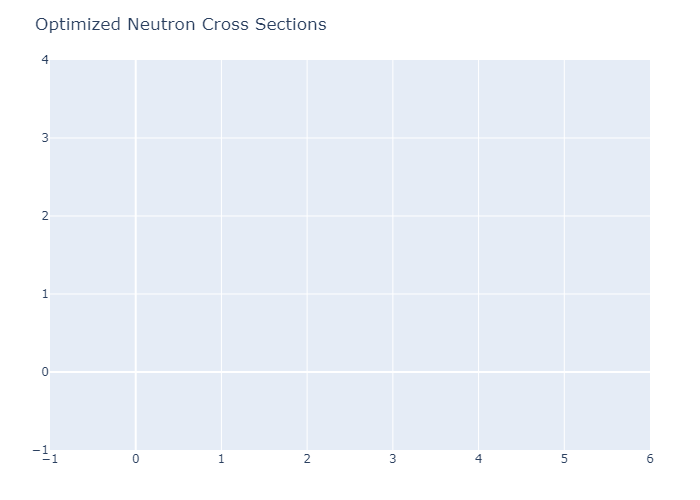

In [119]:
PlotlyJS.plot(neutron_df, x=:"Energy (ev)", y=:"Cross Section (b)", 
    mode="markers", text=:"Target",
    Layout(title="Optimized Neutron Cross Sections"),
    xaxis=:log, yaxis=:log)

In [5]:
file_names = readdir(neutron_dir)
file = file_names[1]
function get_product(file)
    target_n = parse(Int64, file[3:5])
    element, target_z = split(file[7:end-4], "-")
    projectile = file[1]
    if(string(projectile) == "n") #neutron addition
        product_n = target_n
        product_z = parse(Int64, target_z)+1
        product_file = (String("n_") * lpad(product_n, 3, "0") * String("-") * 
                        String(element) * String("-") * lpad(product_z, 3, "0") * String(".dat"))
    end
    return product_file
end
file = file_names[100]
while true
    file = get_product(file)
    if !(file in file_names)
        print(file, " not in directory")
        break 
    end
end

n_026-Fe-061.dat not in directory

In [176]:
function reaction_figure_of_merit(energy_density, mass_number, target_nuclei_per_area, sigma, 
incident_particle_energy)
    #For the product, we take the mass number to be equal to the molar mass
    figure_of_merit = (energy_density * mass_number * 
        target_nuclei_per_area * sigma) / incident_particle_energy
    return uconvert(Unitful.NoUnits, figure_of_merit) 
end

ρ, Z, n, σ, E = @variables ρ, Z, n, σ, E
output = ρ * Z * n * σ / E
print("For output = ", output, "       (unitless)")
Test.@test reaction_figure_of_merit(ρ * @u_str("J/g"), Z * @u_str("g"), 
    n * (@u_str("cm")^-2), σ * @u_str("cm")^2, E * @u_str("J")) - output == 0

For output = (Z*n*ρ*σ) / E       (unitless)

Test Passed
  Expression: reaction_figure_of_merit(ρ * u"J/g", Z * u"g", n * u"cm" ^ -2, σ * u"cm" ^ 2, E * u"J") - output == 0
   Evaluated: 0 == 0

In [11]:
import ENDF6
import plotly.express as px
path = "C:\\Cross-Section-Data\\jendl5-p\\p_001-H-002.dat"
f = open(path)
lines = f.readlines()
sec = ENDF6.find_section(lines, MF=3, MT=28)  # total cross-section
x, y = ENDF6.read_table(sec)
px.scatter(x=x, y=y, labels = {'x':"Proton energy [eV]", 'y' : "Cross-section [barn]"},
log_x = True, log_y = True)


In [21]:
import numpy as np
index = np.argmax(x/y)
x[index], y[index]

(200000000.0, 0.0420456)